In [1]:
import os
os.system('export PYSYN_CDBS=/home/kiran/kurucz_models/grp/hst/cdbs/')
# or
# export PYSYN_CDBS=/media/kiran/New Volume/SEM_6/Internship/kurucz_models/grp/hst/cdbs/
# Run the above line in the command prompt before using this code ... open terminal in folder kurucz_models and type this

import numpy as np
import matplotlib.pyplot as plt
import time
from astropy.io import fits
#import spectres
from scipy.stats import chisquare
from scipy import stats
from astropy import units as u
from astropy import constants as const
import pysynphot as S
import spectres
import csv
import scipy.integrate as integrate

/home/kiran/.local/lib/python3.6/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /home/kiran/kurucz_models/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/home/kiran/.local/lib/python3.6/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /home/kiran/kurucz_models/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/home/kiran/.local/lib/python3.6/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /home/kiran/kurucz_models/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
def reduced_chi_square(x,y,s,m): # ddof = v
    v = x.size - m
    chi2 = (np.sum((x-y)**2/s**2))/v
    p = 1 - stats.chi2.cdf(chi2, v)
    return chi2,p

def get_photometric_flux(m_wave,interpolated_flux,F):
    for X in list(F.keys()):
        w = []
        Sx = []
        with open("{}_2MASS.txt".format(X),'r') as f:
            for line in f:
                y = [float(i) for i in line.split()]
                w.append(y[0]*(10**(-4))) # for converting A to um
                Sx.append(y[1])
        wave = np.array(list(set().union(w,m_wave)))
        wave = np.sort(wave)
        idx = np.where(np.logical_and(wave>=0.3000, wave<=10.0000))
        wave = wave[idx]
        interpolated_Sx = np.interp(wave, w, Sx)
        interpolated_m_flux = np.interp(wave, m_wave, interpolated_flux)
        F[X] = integrate.simps(interpolated_Sx*interpolated_m_flux, wave)/integrate.simps(interpolated_Sx, wave)

    return F


class LessPrecise(float):
    def __repr__(self):
        return str(self)

In [3]:
J = [1.1,1.4]
H = [1.5,1.8]
Ks = [2.0,2.4]
######### USER INPUTS ########
savefig  = False
filename = 'hd101501'
data_dir = os.getcwd()+"/IRTF_data_fit/"
form = '.txt'
flux_error_data = True
conversion_factor = 10**(-4)
##############################

s_wave = []
s_flux = []
a = np.array([])
token = True
with open(data_dir+filename+'/'+ filename+form,'r') as f:
    for line in f:
        if(len(line.split()) == 3):
            if(a.size == 0):
                try:
                    a = np.array([float(i) for i in line.split()])
                except:
                    wave_unit, flux_unit, _ = line.split()                
            else:
                a = np.row_stack((a,[float(i) for i in line.split()]))
f.close()
m_ref = {"J": 0, "H": 0,"KS": 0}
m_err_ref = {"JERR": 0, "HERR": 0,"KSERR": 0}
ctr = 6
q = 0
with open(data_dir+filename+'/'+ filename+form,'r') as f:
    for line in f:
        if(ctr > 0):
            _b = line.split()
            if(q%2 == 0):
                m_ref[_b[1]] = float(_b[3])
            if(q%2 == 1):
                m_err_ref[_b[1]] = float(_b[3])
            q += 1
            ctr -= 1
f.close()
m_ref["Ks"] = m_ref.pop("KS")
#wvl, flx = pyasl.read1dFitsSpec("_bd+622346_20121027_735_cbuil.fits")
a_uv = np.copy(a)
freq_range = [0.3,10.0]
if(wave_unit == "um"):
    while(a[0][0] <= freq_range[0]):
        a = a[1:]
    while(a.T[0,-1] > freq_range[1]):
        a = a[:-2]
else:
    while(a[0][0] <= freq_range[0]*(10**4)):
        a = a[1:]
    while(a.T[0,-1] > freq_range[1]*(10**4)):
        a = a[:-2]
    a.T[0] *= 10**(-4)
    a_uv.T[0] *= 10**(-4)

del_arr = np.where(a.T[1]<0)
a = np.delete(a,del_arr,0)
del_arr = np.where(a_uv.T[1]<0)
a_uv = np.delete(a_uv,del_arr,0)

#m_flux *= np.amax(s_flux)
s_wave = np.array(a.T[0])
s_flux = np.array(a.T[1])#*10**(-3) # convert ergs/s/cm^2/A -> W/cm^2/um by multiplying by (10**(-7))/(10**(-4))                
s_flux_e = np.array(a.T[2])
s_flux = s_flux*conversion_factor # conversion factor given 
s_flux_e = s_flux_e*conversion_factor # conversion factor given 
a_uv.T[1] = a_uv.T[1]*conversion_factor
a_uv.T[2] = a_uv.T[2]*conversion_factor

best_r = 0
best_log_g = 0
best_teff = 0
best_met = 0
p = 0; # in mas
dp = 0;
with open("parallax_values.txt",'r') as f:
    for line in f:
        _a,b,c = line.split()
        if(_a == filename):
            p = float(b)
            dp = float(c)
#p = 109.54 # mas
#dp = 0.17

D = 1000/p * u.parsec
D = D.to(u.m)
dD = (1000/p**2)*dp * u.parsec
dD = dD.to(u.m)

Best fit model parameters: 
Log(g) = 1.0 [0.05]
Teff = 5300 [50] 
[Fe/H] = log_10((Fe/H)star/(Fe/H)sun) = 0.1 [0.05] 
R = 0.9 [0.05] R_sun 
Md = 4.4869275653912874e-18 
Chi-square value = 774.5210565473649 
p value = 1.0
Percentage Mean Residual Value = 4.707518763040609 %


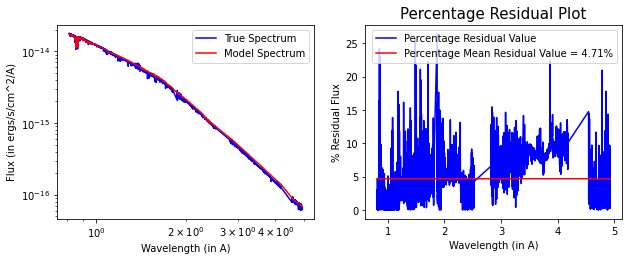

In [23]:
#log_g = np.arange(0,5,1)
#teff = np.arange(3500,10500,2000)
#met = np.arange(-2.5,0.5,0.5)
#Rad = np.array([1,0.1,0.01])

log_g = np.array([1.0])
teff = np.array([5300])
met = np.array([0.1])
Rad = np.array([0.9])

Md = 0
savefig = False

cost= np.inf
chi = np.inf
p = 0
lam = 1000
for t in teff:
    for g in log_g:
        for m in met:
            for r in Rad:
                try:
                    sp = S.Icat('ck04models', t, m, g)
                except:
                    continue
                m_wave = sp.wave*10**(-4)
                m_flux = sp.flux*10**(-3)
                idx = np.where(np.logical_and(m_wave>=freq_range[0]*10**4, m_wave<=freq_range[1]*10**4)) # considering particular frequency range                            
                m_wave = sp.wave*(10**(-4)) # converting A -> um
                m_flux = sp.flux*(10**(-3)) # convert ergs/s/cm^2/A -> W/cm^2/um by multiplying by (10**(-7))/(10**(-4))                

                idx = np.where(np.logical_and(m_wave>=freq_range[0], m_wave<=freq_range[1])) # considering particular frequency range                            
                m_wave = m_wave[idx]
                m_flux = m_flux[idx]

                s_lower_lim = np.argmin(np.abs(s_wave - m_wave[0]))
                s_upper_lim = np.argmin(np.abs(s_wave - m_wave[-1]))

                m_lower_lim = np.argmin(np.abs(m_wave - np.floor(s_wave[0])))
                m_upper_lim = np.argmin(np.abs(m_wave - np.ceil(s_wave[-1])))

                if(m_wave[m_upper_lim] < s_wave[-1]):
                    m_wave = m_wave[m_lower_lim:m_upper_lim+2]
                    m_flux = m_flux[m_lower_lim:m_upper_lim+2]    
                else:
                    m_wave = m_wave[m_lower_lim:m_upper_lim+1]
                    m_flux = m_flux[m_lower_lim:m_upper_lim+1]

                s_wave = s_wave[s_lower_lim:s_upper_lim+1]
                s_flux = s_flux[s_lower_lim:s_upper_lim+1]

                if(flux_error_data):
                    if(m_wave.size > s_wave.size):
                        s_flux_e = s_flux_e[s_lower_lim:s_upper_lim+1]
                        interpolated_flux, interpolated_flux_e = spectres.spectres(m_wave, s_wave, s_flux, s_flux_e)
                        Md = ((r*const.R_sun)/D)**2
                        interpolated_flux = interpolated_flux*Md

                        if(reduced_chi_square(s_flux,interpolated_flux,interpolated_flux_e,4)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100) < cost):
                            cost = reduced_chi_square(s_flux,interpolated_flux,interpolated_flux_e,4)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)
                            chi,p = reduced_chi_square(s_flux,interpolated_flux, interpolated_flux_e,4)
                            best_r = r
                            best_log_g = g
                            best_teff = t
                            best_met = m

                        s_wave = s_wave[:m_wave.size]
                        s_flux = s_flux[:m_wave.size]
                    else:
                        s_flux_e = s_flux_e[s_lower_lim:s_upper_lim+1]
                        interpolated_flux = np.interp(s_wave, m_wave, m_flux)
                        Md = ((r*const.R_sun)/D)**2
                        interpolated_flux = (interpolated_flux*Md).value

                        if(reduced_chi_square(interpolated_flux,s_flux,s_flux_e,4)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100) < cost):
                            cost = reduced_chi_square(interpolated_flux,s_flux,s_flux_e,4)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)
                            chi,p = reduced_chi_square(s_flux,interpolated_flux, s_flux_e,4)
                            best_r = r
                            best_log_g = g
                            best_teff = t
                            best_met = m
                        m_wave = s_wave
                        m_flux = interpolated_flux/Md

                else:
                    if(s_wave.size > m_wave.size):
                        interpolated_flux = np.interp(s_wave, m_wave, m_flux)
                        Md = ((r*const.R_sun)/D)**2
                        interpolated_flux = interpolated_flux*Md

                        if(chisquare(s_flux,interpolated_flux)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100) < cost):
                            cost = chisquare(s_flux,interpolated_flux)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)
                            chi,p = chisquare(s_flux,interpolated_flux)
                            best_r = r
                            best_log_g = g
                            best_teff = t
                            best_met = m
                        m_wave = s_wave
                        m_flux = interpolated_flux/Md
                    else:
                        interpolated_flux = np.interp(m_wave, s_wave, s_flux)
                        Md = ((r*const.R_sun)/D)**2
                        s_flux = np.copy(interpolated_flux)

                        if(chisquare(s_flux,interpolated_flux)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100) < cost):
                            cost = chisquare(s_flux,interpolated_flux)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)
                            chi,p = chisquare(s_flux,interpolated_flux)
                            best_r = r
                            best_log_g = g
                            best_teff = t
                            best_met = m
                        interpolated_flux = m_flux*Md
                        s_wave = m_wave

print("Best fit model parameters: \nLog(g) = {} [{}]\nTeff = {} [{}] \n[Fe/H] = log_10((Fe/H)star/(Fe/H)sun) = {} [{}] \nR = {} [{:0.2f}] R_sun \nMd = {} \nChi-square value = {} \np value = {}".format(best_log_g,0.05,best_teff,50,best_met,0.05,best_r,np.amax([0.05,np.abs(np.sqrt(Md)*(dD/const.R_sun))]),Md,chi,p))
print("Percentage Mean Residual Value = {} %".format(np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)))

t_f = 15
n_row = 1
n_col = 2
fig = plt.figure(figsize=(4 * n_col, 3 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)

ax = fig.add_subplot(n_row,n_col,1)
#plt.loglog(a_uv.T[0],a_uv.T[1],'r')
plt.loglog(s_wave,s_flux,'b')
plt.loglog(m_wave,m_flux*Md,'r')
#plt.loglog(s_wave,s_flux+s_flux_e,'--b')
#plt.loglog(s_wave,s_flux-s_flux_e,'--b')
plt.xlabel("Wavelength (in A)")
plt.ylabel("Flux (in ergs/s/cm^2/A)")
plt.legend(["True Spectrum","Model Spectrum"])

ax = fig.add_subplot(n_row,n_col,2)
plt.plot(m_wave,(np.abs(interpolated_flux-s_flux)/s_flux)*100,'b')
plt.plot(m_wave, np.ones(m_wave.size)*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100),'r')
plt.xlabel("Wavelength (in A)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100))])
#plt.savefig(data_directory+"new_selected/"+filename+"m25.png")                


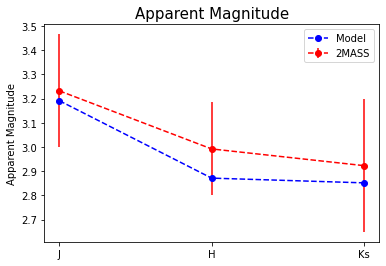

In [6]:
F = {"J":0, "H":0, "Ks":0}
F = get_photometric_flux(m_wave,interpolated_flux,F)
effective_wave = {"J": 1.249498, "H": 1.646724, "Ks": 2.164089}
#J_ref = 1.60*(10**(-20))*(10**(-7))*(u.W/(u.cm)**2)*const.c.to(u.um/u.s)*u.s*(1/(effective_wave['J']*u.um)**2)
#H_ref = 1.08*(10**(-20))*(10**(-7))*(u.W/(u.cm)**2)*const.c.to(u.um/u.s)*u.s*(1/(effective_wave['H']*u.um)**2)
#Ks_ref = 0.67*(10**(-20))*(10**(-7))*(u.W/(u.cm)**2)*const.c.to(u.um/u.s)*u.s*(1/(effective_wave['Ks']*u.um)**2)
J_ref = 1594.0*(10**(-26))*(10**(-4))*(u.W/(u.cm)**2)*const.c.to(u.um/u.s)*u.s*(1/(effective_wave['J']*u.um)**2)
H_ref = 1024.0*(10**(-26))*(10**(-4))*(u.W/(u.cm)**2)*const.c.to(u.um/u.s)*u.s*(1/(effective_wave['H']*u.um)**2)
Ks_ref = 666.8*(10**(-26))*(10**(-4))*(u.W/(u.cm)**2)*const.c.to(u.um/u.s)*u.s*(1/(effective_wave['Ks']*u.um)**2)

m = {"J":0, "H":0, "Ks":0}

m['J'] = -2.5*np.log10(F['J']/J_ref.value)
m['H'] = -2.5*np.log10(F['H']/H_ref.value)
m['Ks'] = -2.5*np.log10(F['Ks']/Ks_ref.value)

plt.plot(list(m.keys()), list(m.values()), linestyle='--', marker='o', color='b')
plt.errorbar(list(m_ref.keys()), list(m_ref.values()),
            yerr=list(m_err_ref.values()),
            fmt='--ro')
plt.ylabel("Apparent Magnitude")
plt.legend(["Model","2MASS"])
plt.title("Apparent Magnitude", fontsize=t_f)
plt.savefig(data_dir+"new_IRTF/"+filename+"_mag.png")

In [9]:
Ks_ref

<Quantity 4.26840932e-14 W / (cm2 um)>

In [116]:
for k, v in m.items():
    v = LessPrecise(round(v, 2))
    print (k,v)

J 3.14
H 2.87
Ks 2.86


Text(0.5, 1.0, 'Percentage Residual Plot (J Band)')

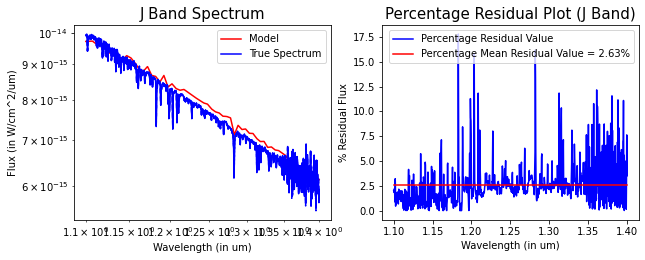

In [24]:
t_f = 15
n_row = 1
n_col = 2
fig = plt.figure(figsize=(4 * n_col, 3 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)


ax = fig.add_subplot(n_row,n_col,1)
idx = np.where(np.logical_and(s_wave>=J[0], s_wave<=J[1]))
plt.loglog(s_wave[idx],interpolated_flux[idx],'r')
plt.loglog(s_wave[idx],s_flux[idx],'b')
plt.loglog(s_wave[idx],s_flux[idx]+s_flux_e[idx],'--b')
plt.loglog(s_wave[idx],s_flux[idx]-s_flux_e[idx],'--b')
plt.xlabel("Wavelength (in um)")
plt.ylabel("Flux (in W/cm^2/um)")
plt.legend(["Model","True Spectrum"])
plt.title("J Band Spectrum",fontsize=t_f)

ax = fig.add_subplot(n_row,n_col,2)
idx = np.where(np.logical_and(m_wave>=J[0], m_wave<=J[1]))
plt.plot(m_wave[idx],(np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100,'b')
plt.plot(m_wave[idx],np.ones(m_wave[idx].size)*np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100),'r')
#plt.loglog(m_wave,m_flux*Md,'g')
plt.xlabel("Wavelength (in um)")
plt.ylabel("% Residual Flux")
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])
plt.title("Percentage Residual Plot (J Band)",fontsize=t_f)
#plt.savefig(data_dir+"new_IRTF/"+filename+"_J.png")

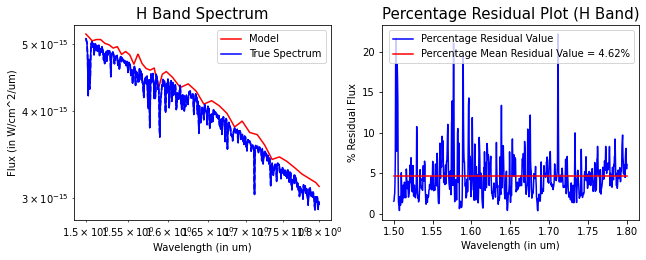

In [25]:
t_f = 15
n_row = 1
n_col = 2
fig = plt.figure(figsize=(4 * n_col, 3 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)


ax = fig.add_subplot(n_row,n_col,1)
idx = np.where(np.logical_and(s_wave>=H[0], s_wave<=H[1]))
plt.loglog(s_wave[idx],interpolated_flux[idx],'r')
plt.loglog(s_wave[idx],s_flux[idx],'b')
plt.loglog(s_wave[idx],s_flux[idx]+s_flux_e[idx],'--b')
plt.loglog(s_wave[idx],s_flux[idx]-s_flux_e[idx],'--b')
plt.xlabel("Wavelength (in um)")
plt.ylabel("Flux (in W/cm^2/um)")
plt.legend(["Model","True Spectrum"])
plt.title("H Band Spectrum",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 2)
idx = np.where(np.logical_and(m_wave>=H[0], m_wave<=H[1]))
plt.plot(m_wave[idx],(np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100,'b')
plt.plot(m_wave[idx],np.ones(m_wave[idx].size)*np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100),'r')
#plt.loglog(m_wave,m_flux*Md,'g')
plt.xlabel("Wavelength (in um)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot (H Band)",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])

#plt.savefig(data_dir+"new_IRTF/"+filename+"_H.png")

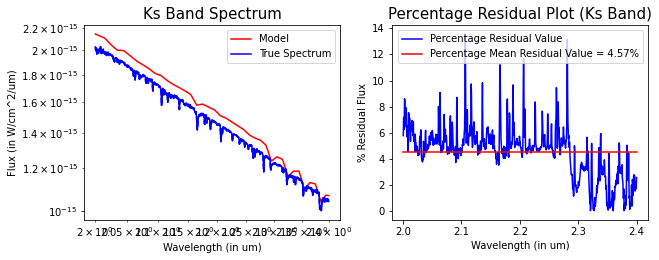

In [26]:
t_f = 15
n_row = 1
n_col = 2
fig = plt.figure(figsize=(4 * n_col, 3 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)


ax = fig.add_subplot(n_row,n_col,1)
idx = np.where(np.logical_and(s_wave>=Ks[0], s_wave<=Ks[1]))
plt.loglog(s_wave[idx],interpolated_flux[idx],'r')
plt.loglog(s_wave[idx],s_flux[idx],'b')
plt.loglog(s_wave[idx],s_flux[idx]+s_flux_e[idx],'--b')
plt.loglog(s_wave[idx],s_flux[idx]-s_flux_e[idx],'--b')
plt.xlabel("Wavelength (in um)")
plt.ylabel("Flux (in W/cm^2/um)")
plt.legend(["Model","True Spectrum"])
plt.title("Ks Band Spectrum",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 2)
idx = np.where(np.logical_and(m_wave>=Ks[0], m_wave<=Ks[1]))
plt.plot(m_wave[idx],(np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100,'b')
plt.plot(m_wave[idx],np.ones(m_wave[idx].size)*np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100),'r')
#plt.loglog(m_wave,m_flux*Md,'g')
plt.xlabel("Wavelength (in um)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot (Ks Band)",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])
#plt.savefig(data_dir+"new_IRTF/"+filename+"_Ks.png")

In [120]:
w = csv.writer(open(data_dir+"new_IRTF/"+filename+"_apparent_magnitude.csv", "w"))
for key, val in m.items():
    w.writerow([key, val])

In [121]:
w = csv.writer(open(data_dir+"new_IRTF/"+filename+"_photometric_flux.csv", "w"))
for key, val in F.items():
    w.writerow([key, val])

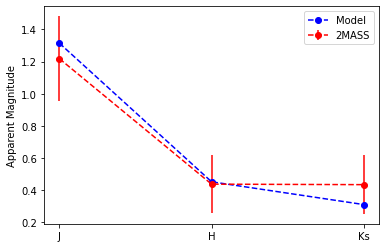

In [192]:
'''t_f = 20
n_row = 5
n_col = 2
fig = plt.figure(figsize=(8 * n_col, 6 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)


ax = fig.add_subplot(n_row,n_col,1)
#plt.loglog(a_uv.T[0],a_uv.T[1],'r')
plt.loglog(s_wave,s_flux,'b')
plt.loglog(m_wave,m_flux*Md,'r')
plt.loglog(s_wave,s_flux+s_flux_e,'--b')
plt.loglog(s_wave,s_flux-s_flux_e,'--b')
plt.xlabel("Wavelength (in um)")
plt.ylabel("Flux (in W/cm^2/um)")
plt.legend(["True Spectrum","Model Spectrum"])

ax = fig.add_subplot(n_row,n_col,2)
fig.subplots_adjust(top=0.85)
plt.xticks(())
plt.yticks(())
#ax.set_xlabel('xlabel')
#ax.set_ylabel('ylabel')
ax.text(0.02, 0.2, "Best fit model parameters: \nLog(g) = {} [{}]\nTeff = {} [{}] \n[Fe/H] = log_10((Fe/H)star/(Fe/H)sun) = {} [{}] \nR = {} [{}] R_sun \nMd = {} \nChi-square value = {} \np value = {}".format(best_log_g,0.05,best_teff,50,best_met,0.05,best_r,np.amax([0.05,np.abs(np.sqrt(Md)*(dD/const.R_sun))]),Md,chi,p),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes, fontsize=20)

ax = fig.add_subplot(n_row, n_col, 3)
m_ref = {'J': 3.527, 'H': 3.23, 'Ks': 3.033}
plt.plot(list(m.keys()), list(m.values()), linestyle='--', marker='o', color='b')
plt.errorbar(list(m_ref.keys()), list(m_ref.values()),
            yerr=[0.266,0.208,0.256],
            fmt='--ro')
plt.ylabel("Apparent Magnitude")
plt.legend(["Model","2MASS"])
plt.title("Apparent Magnitude", fontsize=t_f)
#plt.savefig("{}_apparent_mag_plot.png".format(filename))

ax = fig.add_subplot(n_row, n_col, 4)
plt.plot(m_wave,(np.abs(interpolated_flux-s_flux)/s_flux)*100,'b')
plt.plot(m_wave,np.ones(m_wave.size)*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100),'r')
plt.xlabel("Wavelength (in um)")
plt.ylabel("% Residual Flux")
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100))])
plt.title("Percentage Residual Plot",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 5)
idx = np.where(np.logical_and(s_wave>=J[0], s_wave<=J[1]))
plt.loglog(s_wave[idx],interpolated_flux[idx],'r')
plt.loglog(s_wave[idx],s_flux[idx],'b')
plt.loglog(s_wave[idx],s_flux[idx]+s_flux_e[idx],'--b')
plt.loglog(s_wave[idx],s_flux[idx]-s_flux_e[idx],'--b')
plt.xlabel("Wavelength (in um)")
plt.ylabel("Flux (in W/cm^2/um)")
plt.legend(["Model","True Spectrum"])
plt.title("J Band Spectrum",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 6)
idx = np.where(np.logical_and(m_wave>=J[0], m_wave<=J[1]))
plt.plot(m_wave[idx],(np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100,'b')
plt.plot(m_wave[idx],np.ones(m_wave[idx].size)*np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100),'r')
#plt.loglog(m_wave,m_flux*Md,'g')
plt.xlabel("Wavelength (in um)")
plt.ylabel("% Residual Flux")
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])
plt.title("Percentage Residual Plot (J Band)",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 7)
idx = np.where(np.logical_and(s_wave>=H[0], s_wave<=H[1]))
plt.loglog(s_wave[idx],interpolated_flux[idx],'r')
plt.loglog(s_wave[idx],s_flux[idx],'b')
plt.loglog(s_wave[idx],s_flux[idx]+s_flux_e[idx],'--b')
plt.loglog(s_wave[idx],s_flux[idx]-s_flux_e[idx],'--b')
plt.xlabel("Wavelength (in um)")
plt.ylabel("Flux (in W/cm^2/um)")
plt.legend(["Model","True Spectrum"])
plt.title("H Band Spectrum",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 8)
idx = np.where(np.logical_and(m_wave>=H[0], m_wave<=H[1]))
plt.plot(m_wave[idx],(np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100,'b')
plt.plot(m_wave[idx],np.ones(m_wave[idx].size)*np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100),'r')
#plt.loglog(m_wave,m_flux*Md,'g')
plt.xlabel("Wavelength (in um)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot (H Band)",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])
            
ax = fig.add_subplot(n_row, n_col, 9)
idx = np.where(np.logical_and(s_wave>=Ks[0], s_wave<=Ks[1]))
plt.loglog(s_wave[idx],interpolated_flux[idx],'r')
plt.loglog(s_wave[idx],s_flux[idx],'b')
plt.loglog(s_wave[idx],s_flux[idx]+s_flux_e[idx],'--b')
plt.loglog(s_wave[idx],s_flux[idx]-s_flux_e[idx],'--b')
plt.xlabel("Wavelength (in um)")
plt.ylabel("Flux (in W/cm^2/um)")
plt.legend(["Model","True Spectrum"])
plt.title("Ks Band Spectrum",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 10)
idx = np.where(np.logical_and(m_wave>=Ks[0], m_wave<=Ks[1]))
plt.plot(m_wave[idx],(np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100,'b')
plt.plot(m_wave[idx],np.ones(m_wave[idx].size)*np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100),'r')
#plt.loglog(m_wave,m_flux*Md,'g')
plt.xlabel("Wavelength (in um)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot (Ks Band)",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])
#plt.savefig("{}.png".format(filename))

m_ref = {'J': 1.218, 'H': 0.438, 'Ks': 0.435}
fig, ax = plt.subplots()
ax.plot(list(m.keys()), list(m.values()), linestyle='--', marker='o', color='b')
ax.errorbar(list(m_ref.keys()), list(m_ref.values()),
            yerr=[0.264,0.18,0.182],
            fmt='--ro')
plt.ylabel("Apparent Magnitude")
ax.legend(["Model","2MASS"])
plt.savefig("{}_apparent_mag_plot.png".format(filename))'''

In [ ]:
# only chi squared minimization -> not included in cost function the residual values
'''#log_g = np.arange(0,5,1)
#teff = np.arange(3500,10500,2000)
#met = np.arange(-2.5,0.5,0.5)
#Rad = np.array([1,0.1,0.01])

log_g = np.array([4.3])
teff = np.array([5900])
met = np.array([0.1])
Rad = np.array([1.1])

Md = 0
savefig = False

chi = np.inf
p = 0
for t in teff:
    for g in log_g:
        for m in met:
            for r in Rad:
                try:
                    sp = S.Icat('ck04models', t, m, g)
                except:
                    continue
                m_wave = sp.wave*10**(-4)
                m_flux = sp.flux*10**(-3)
                idx = np.where(np.logical_and(m_wave>=freq_range[0]*10**4, m_wave<=freq_range[1]*10**4)) # considering particular frequency range                            
                m_wave = sp.wave*(10**(-4)) # converting A -> um
                m_flux = sp.flux*(10**(-3)) # convert ergs/s/cm^2/A -> W/cm^2/um by multiplying by (10**(-7))/(10**(-4))                

                idx = np.where(np.logical_and(m_wave>=freq_range[0], m_wave<=freq_range[1])) # considering particular frequency range                            
                m_wave = m_wave[idx]
                m_flux = m_flux[idx]

                s_lower_lim = np.argmin(np.abs(s_wave - m_wave[0]))
                s_upper_lim = np.argmin(np.abs(s_wave - m_wave[-1]))

                m_lower_lim = np.argmin(np.abs(m_wave - np.floor(s_wave[0])))
                m_upper_lim = np.argmin(np.abs(m_wave - np.ceil(s_wave[-1])))

                if(m_wave[m_upper_lim] < s_wave[-1]):
                    m_wave = m_wave[m_lower_lim:m_upper_lim+2]
                    m_flux = m_flux[m_lower_lim:m_upper_lim+2]    
                else:
                    m_wave = m_wave[m_lower_lim:m_upper_lim+1]
                    m_flux = m_flux[m_lower_lim:m_upper_lim+1]

                s_wave = s_wave[s_lower_lim:s_upper_lim+1]
                s_flux = s_flux[s_lower_lim:s_upper_lim+1]
                
                if(flux_error_data):
                    if(m_wave.size > s_wave.size):
                        s_flux_e = s_flux_e[s_lower_lim:s_upper_lim+1]
                        interpolated_flux, interpolated_flux_e = spectres.spectres(m_wave, s_wave, s_flux, s_flux_e)
                        Md = ((r*const.R_sun)/D)**2
                        interpolated_flux = interpolated_flux*Md

                        if(reduced_chi_square(s_flux,interpolated_flux,interpolated_flux_e,4)[0] < chi):
                            chi,p = reduced_chi_square(s_flux,interpolated_flux, interpolated_flux_e,4)
                            best_r = r
                            best_log_g = g
                            best_teff = t
                            best_met = m

                        s_wave = s_wave[:m_wave.size]
                        s_flux = s_flux[:m_wave.size]
                    else:
                        s_flux_e = s_flux_e[s_lower_lim:s_upper_lim+1]
                        interpolated_flux = np.interp(s_wave, m_wave, m_flux)
                        Md = ((r*const.R_sun)/D)**2
                        interpolated_flux = (interpolated_flux*Md).value

                        if(reduced_chi_square(s_flux,interpolated_flux,s_flux_e,4)[0] < chi):
                            chi,p = reduced_chi_square(s_flux,interpolated_flux, s_flux_e,4)
                            best_r = r
                            best_log_g = g
                            best_teff = t
                            best_met = m
                        m_wave = s_wave
                        m_flux = interpolated_flux/Md

                else:
                    if(s_wave.size > m_wave.size):
                        interpolated_flux = np.interp(s_wave, m_wave, m_flux)
                        Md = ((r*const.R_sun)/D)**2
                        interpolated_flux = interpolated_flux*Md

                        if(chisquare(s_flux,interpolated_flux)[0] < chi):
                            chi,p = chisquare(s_flux,interpolated_flux)
                            best_r = r
                            best_log_g = g
                            best_teff = t
                            best_met = m
                        m_wave = s_wave
                        m_flux = interpolated_flux/Md
                    else:
                        interpolated_flux = np.interp(m_wave, s_wave, s_flux)
                        Md = ((r*const.R_sun)/D)**2
                        s_flux = np.copy(interpolated_flux)

                        if(chisquare(s_flux,interpolated_flux)[0] < chi):
                            chi,p = chisquare(s_flux,interpolated_flux)
                            best_r = r
                            best_log_g = g
                            best_teff = t
                            best_met = m
                        interpolated_flux = m_flux*Md
                        s_wave = m_wave

print("Best fit model parameters: \nLog(g) = {} [{}]\nTeff = {} [{}] \n[Fe/H] = log_10((Fe/H)star/(Fe/H)sun) = {} [{}] \nR = {} [{:0.2f}] R_sun \nMd = {} \nChi-square value = {} \np value = {}".format(best_log_g,0.05,best_teff,50,best_met,0.05,best_r,np.amax([0.05,np.abs(np.sqrt(Md)*(dD/const.R_sun))]),Md,chi,p))
print("Percentage Mean Residual Value = {} %".format(np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)))

t_f = 15
n_row = 1
n_col = 2
fig = plt.figure(figsize=(4 * n_col, 3 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)

ax = fig.add_subplot(n_row,n_col,1)
#plt.loglog(a_uv.T[0],a_uv.T[1],'r')
plt.loglog(s_wave,s_flux,'b')
plt.loglog(m_wave,m_flux*Md,'r')
#plt.loglog(s_wave,s_flux+s_flux_e,'--b')
#plt.loglog(s_wave,s_flux-s_flux_e,'--b')
plt.xlabel("Wavelength (in A)")
plt.ylabel("Flux (in ergs/s/cm^2/A)")
plt.legend(["True Spectrum","Model Spectrum"])

ax = fig.add_subplot(n_row,n_col,2)
plt.plot(m_wave,(np.abs(interpolated_flux-s_flux)/s_flux)*100,'b')
plt.plot(m_wave, np.ones(m_wave.size)*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100),'r')
plt.xlabel("Wavelength (in A)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100))])
#plt.savefig(data_directory+"new_selected/"+filename+"m25.png")'''